In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import nltk
from collections import Counter
import pandas as pd
from nltk.util import ngrams
from nltk.corpus import stopwords
import os


In [6]:
file_path = os.path.join(os.path.dirname(os.getcwd()), 'Crawling')
save_path = os.path.join(os.getcwd(), 'Saved CSV')

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')

In [9]:
with open(os.path.join(file_path, 'David_Copperfield.txt'), 'r', encoding='utf-8') as file:
    text = file.read()

In [12]:
text = text.lower()

sentenced_text = text.replace("\n", " ")
sentenced_text = re.sub(r'\s+', ' ', text).strip()
text = re.sub(r'\d+', '', text)  
text = re.sub(r'[^\w\s]', '', text) 

tokens = nltk.word_tokenize(text)
tagged_words = nltk.pos_tag(tokens)
sentences = nltk.sent_tokenize(sentenced_text)

words = text.split()

### WordCloud in python

In [16]:
# Get standard stopwords
stop_words = set(stopwords.words('english'))

# Add custom stopwords for novels (speech verbs, function words, common verbs etc.)
custom_stops = {"said", "replied", "asked", "went", "came", "saw", "looked",
                "mr", "mrs", "miss", "sir", "upon", "though", "yet", "still",
                "come", "came", "go", "going", "got", "put", "take", "took",
                "make", "made", "say", "said", "see", "saw", "know", "knew",
                "the", "i", "and", "to", "of", "a", "in", "was", "my", "that",
                "it", "her", "me", "he", "you", "with", "as", "had", "his", 
                "she", "at", "for", "have", "on", "but", "be", "not", "is",
                "so", "him", "when", "if", "all", "we", "this", "by", "what",
                "which", "were", "no", "been", "there", "out", "from", "or",
                "would", "an", "do", "one", "up", "am", "could", "are", "now",
                "any", "some", "never", "who", "should", "much", "about",
                "them", "then", "how", "like", "down", "your", "us", "well",
                "being", "such", "will", "dont", "again", "did", "after",
                "away", "has", "might", "over", "too", "own", "quite", "here",
                "back", "where"}

stop_words.update(custom_stops)

words_for_wordcloud = [word for word in words if word not in stop_words and len(word) > 2]

joined_text = ' '.join(words_for_wordcloud)

In [17]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(joined_text)

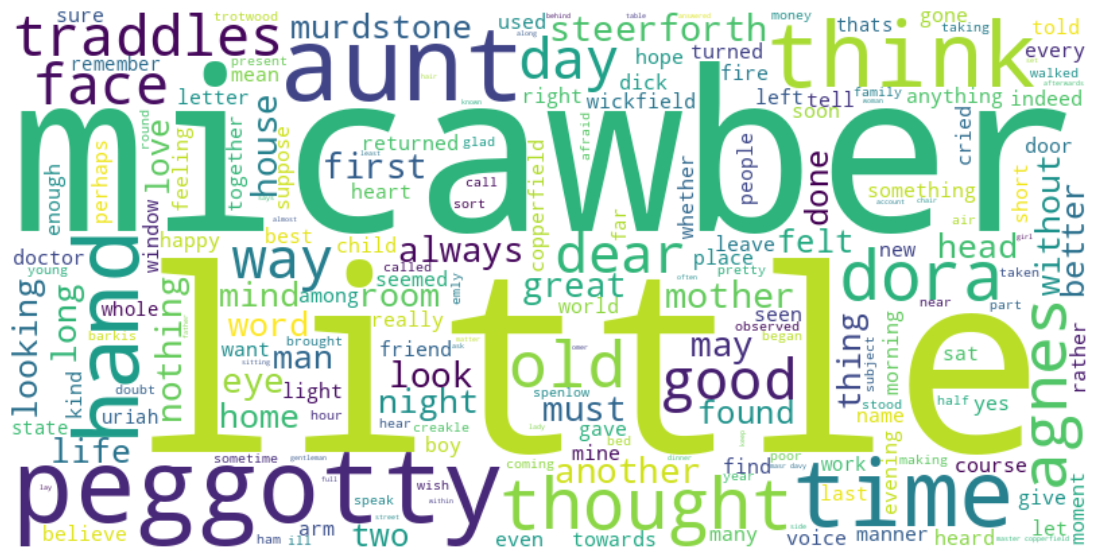

In [19]:
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Wordcloud

In [26]:
word_counts = Counter(words)
df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
df.to_csv(save_path + '\wordcloud_powerbi.csv', index=False)

### Word Frequency

In [27]:
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
word_freq_df.to_csv(save_path + '\word_frequency.csv', index=False)


### POS Frequency

In [28]:
def simplify_pos(tag):
    if tag.startswith('NN'):
        return 'Noun'
    elif tag.startswith('VB'):
        return 'Verb'
    elif tag.startswith('JJ'):
        return 'Adjective'
    elif tag.startswith('RB'):
        return 'Adverb'
    else:
        return 'Other'

In [29]:
pos_categories = [simplify_pos(tag) for _, tag in tagged_words]
pos_counts = Counter(pos_categories)

In [30]:
df_pos = pd.DataFrame(pos_counts.items(), columns=['POS', 'Count'])
df_pos.to_csv(save_path + '\pos_counts_powerbi.csv', index=False)

### POS Transfer

In [31]:
transition_counts = Counter()
for i in range(len(pos_categories) - 1):
    from_pos = pos_categories[i]
    to_pos = pos_categories[i + 1]
    transition_counts[(from_pos, to_pos)] += 1


In [32]:
df_transitions = pd.DataFrame(
    [(from_pos, to_pos, count) for (from_pos, to_pos), count in transition_counts.items()],
    columns=['From_POS', 'To_POS', 'Count']
)
df_transitions.to_csv(save_path + '\pos_transitions_powerbi.csv', index=False)

### Bigrams

In [33]:
bigrams = list(ngrams(tokens, 2))
bigrams_freq = Counter(bigrams)

In [34]:
bigram_freq_df = pd.DataFrame(bigrams_freq.items(), columns=['Bigram', 'Frequency']).sort_values(by='Frequency', ascending=False)
bigram_freq_df.to_csv(save_path + '\\bigram_frequency.csv', index=False)

### Trigrams

In [35]:
trigrams = list(ngrams(tokens, 3))
trigram_freq = Counter(trigrams)

In [37]:
trigram_freq_df = pd.DataFrame(trigram_freq.items(), columns=['Trigram', 'Frequency']).sort_values(by='Frequency', ascending=False)
trigram_freq_df.to_csv(save_path + '\\trigram_frequency.csv', index=False)

### Depth

In [38]:
distances = []
last_seen = {'Noun': -1, 'Verb': -1, 'Adjective': -1}

In [39]:
for i, (word, tag) in enumerate(tagged_words):
    simple = simplify_pos(tag)
    
    distance_info = {
        'Word': word,
        'POS': simple,
        'Distance_from_last_Noun': i - last_seen['Noun'] if last_seen['Noun'] != -1 else None,
        'Distance_from_last_Verb': i - last_seen['Verb'] if last_seen['Verb'] != -1 else None,
        'Distance_from_last_Adjective': i - last_seen['Adjective'] if last_seen['Adjective'] != -1 else None
    }
    
    if simple in last_seen:
        last_seen[simple] = i

    distances.append(distance_info)

In [40]:
df = pd.DataFrame(distances)
df.to_csv(save_path + '\distance_from_last_pos.csv', index=False)

### Word Count Per Sent

In [41]:
word_counts = [len(nltk.word_tokenize(sentence)) for sentence in sentences]

In [42]:
df = pd.DataFrame(word_counts, columns=['Word Count'])
df.to_csv(save_path + '\word_count_per_sentence.csv', index=True)

### POS diversity

In [43]:
def pos_diversity(sentence):
    words = nltk.word_tokenize(sentence)
    if not words:
        return 0
    pos_tags = [tag for _, tag in nltk.pos_tag(words)]
    return len(set(pos_tags)) / len(pos_tags)

In [44]:
diversity_scores = [pos_diversity(sentence) for sentence in sentences]

In [45]:
df = pd.DataFrame(diversity_scores, columns=['POS Diversity'])
df.to_csv(save_path + '\pos_diversity_per_sentence.csv', index=True)